In [1]:
import glob
import os

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy.api as sc

%matplotlib inline

/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
gene_cell_table = pd.read_csv('s3://czbiohub-seqbot/fastqs/180516_A00111_0149_AH5CM2DSXX/results/ashleys_gct.csv', index_col=0)
print(gene_cell_table.shape)
gene_cell_table.head()

(26582, 4974)


,A10_B000419_S34.homo,A10_B000420_S82.homo,A10_B002073_S166.homo,A10_B002078_S202.homo,A10_B002095_S118.homo,A10_B002097_S250.homo,A10_B003125_S262.homo,A10_B003511_S214.homo,A10_B003527_S130.homo,A10_B003528_S10.homo,...,P9_B002095_S177.homo,P9_B002097_S9.homo,P9_B003125_S21.homo,P9_B003511_S273.homo,P9_B003527_S189.homo,P9_B003528_S69.homo,P9_B003570_S153.homo,P9_B003573_S237.homo,P9_B003586_S57.homo,P9_B003588_S105.homo
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,0,0
A1BG-AS1,0,0,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,221,0,0,0,...,0,0,0,0,0,14149,0,0,0,0
A2M-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
gene_cell_table.columns = gene_cell_table.columns.map(lambda x: x.split('.')[0])
gene_cell_table.head()

,A10_B000419_S34,A10_B000420_S82,A10_B002073_S166,A10_B002078_S202,A10_B002095_S118,A10_B002097_S250,A10_B003125_S262,A10_B003511_S214,A10_B003527_S130,A10_B003528_S10,...,P9_B002095_S177,P9_B002097_S9,P9_B003125_S21,P9_B003511_S273,P9_B003527_S189,P9_B003528_S69,P9_B003570_S153,P9_B003573_S237,P9_B003586_S57,P9_B003588_S105
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,0,0
A1BG-AS1,0,0,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,221,0,0,0,...,0,0,0,0,0,14149,0,0,0,0
A2M-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
X = gene_cell_table.T
print(X.shape)
X.head()

(4974, 26582)


gene,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique
A10_B000419_S34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,60903,1,0,0,10151
A10_B000420_S82,18,0,0,0,0,0,0,0,0,0,...,0,0,11,0,0,28971,903,0,0,161026
A10_B002073_S166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,52492,2030,0,0,491754
A10_B002078_S202,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,724529,8380,0,0,2390973
A10_B002095_S118,0,0,0,0,0,0,0,0,4,0,...,1,18,1,129,162,574934,15903,0,0,1620778


In [5]:
results_file = '/mnt/data/lung_cancer.h5ad'


sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

scanpy==1.2.2 anndata==0.6.6 numpy==1.15.0 scipy==1.1.0 pandas==0.23.3 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [6]:
sc.logging.print_memory_usage()

Memory usage: current 2.44 GB, difference +2.44 GB


In [7]:
from anndata import AnnData

In [8]:
obs = pd.DataFrame(index=X.index)
var = pd.DataFrame(index=X.columns)

In [9]:
lung_cancer = AnnData(X.values, obs=obs, var=var)
lung_cancer

AnnData object with n_obs × n_vars = 4974 × 26582 

In [10]:
lung_cancer.var_names_make_unique()
lung_cancer

AnnData object with n_obs × n_vars = 4974 × 26582 

In [11]:
sc.pp.filter_cells(lung_cancer, min_genes=500)
sc.pp.filter_genes(lung_cancer, min_cells=3)

In [12]:
lung_cancer

AnnData object with n_obs × n_vars = 3155 × 23807 
    obs: 'n_genes'
    var: 'n_cells'

In [13]:
adata = lung_cancer

In [14]:
mito_genes = [name for name in adata.var_names if name.startswith('Mt')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


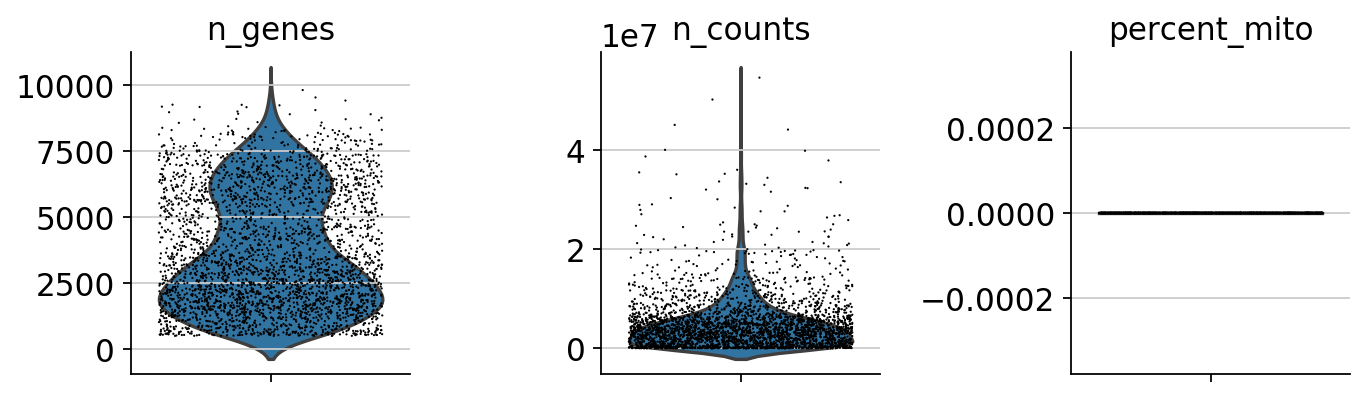

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

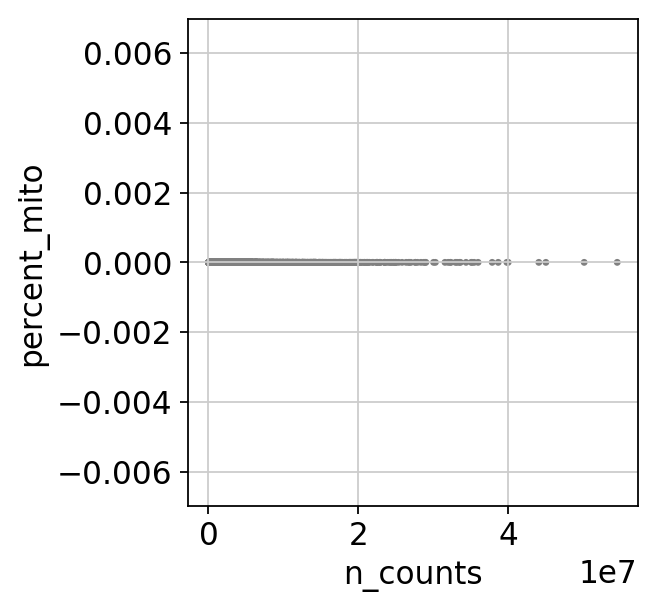

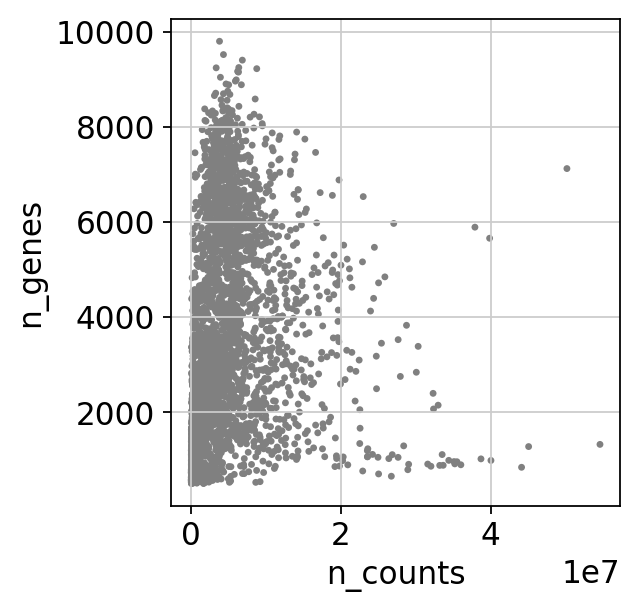

In [16]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [17]:
adata = adata[adata.obs['n_genes'] < 10000, :]
adata

View of AnnData object with n_obs × n_vars = 3155 × 23807 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [18]:
# adata.raw = sc.pp.log1p(adata, copy=True)

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

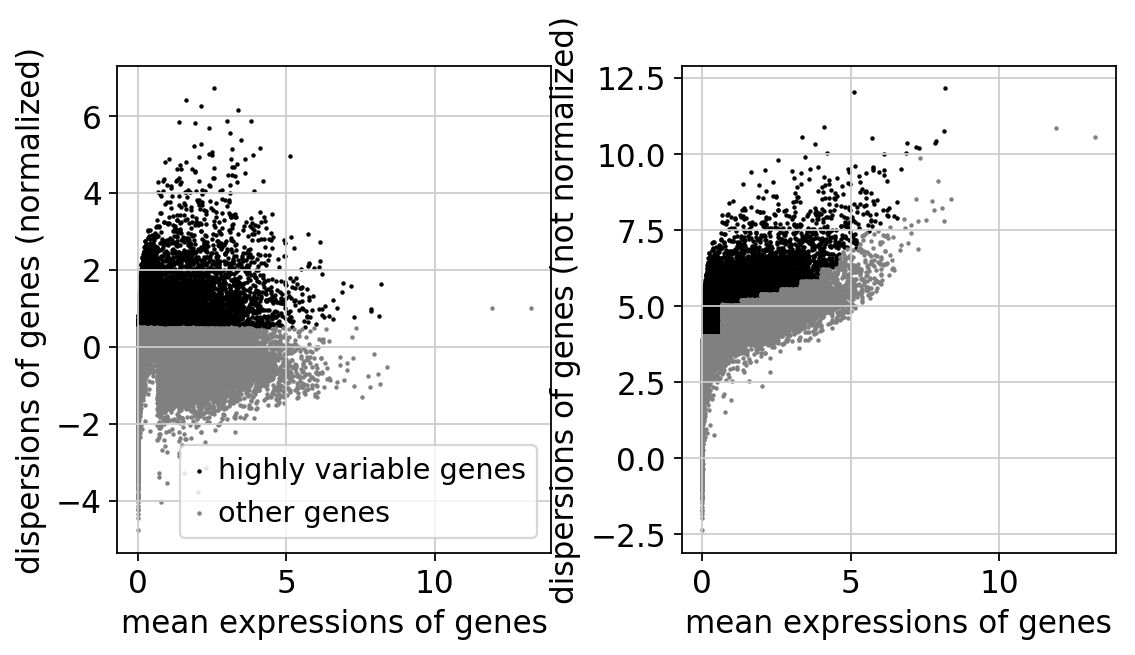

In [20]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=10, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [21]:
filter_result

rec.array([(False,  1.285163  ,  4.413613, -0.31896466),
           ( True,  0.405538  ,  4.17147 ,  0.6241248 ),
           (False,  0.06506266,  3.763011,  0.28736338), ...,
           (False, 11.911734  , 10.847689,  1.        ),
           (False,  8.152362  ,  7.794963, -0.96357286),
           (False, 13.237636  , 10.540678,  1.        )],
          dtype=[('gene_subset', '?'), ('means', '<f4'), ('dispersions', '<f4'), ('dispersions_norm', '<f4')])

In [22]:
adata = adata[:, filter_result.gene_subset]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 3155 × 6410 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [24]:
adata.obsm

ArrayView([(), (), (), ..., (), (), ()], dtype=[])

In [25]:
# sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
adata.write(results_file)


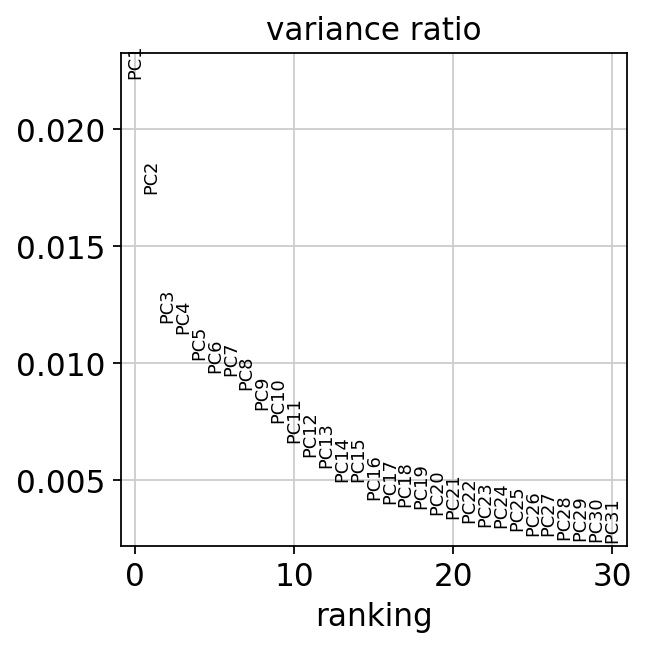

In [26]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)


In [27]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 3155 × 6410 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [28]:
n_pcs = 4

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata)

/home/ubuntu/anaconda/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:123: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


In [ ]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color='louvain')

In [ ]:
range(3)

In [ ]:
%%time

sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.logging.print_memory_usage()


In [ ]:
sc.__version__

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=10)

In [ ]:
top_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top_genes.head()

In [ ]:
top_genes_top_per_cluster = np.unique(top_genes.iloc[:, :2].values.flat)
len(top_genes_top_per_cluster)

In [ ]:
from itertools import islice

In [ ]:
chunksize = 4

n_chunks = int(np.ceil(len(top_genes_top_per_cluster)/chunksize))

for i in range(n_chunks):
    start = i*chunksize
    stop = i*chunksize + chunksize
    genes = top_genes_top_per_cluster[start:stop]
    print(genes)
    
    sc.pl.umap(adata, color=genes)

In [ ]:
sc.pl.umap(adata, color=top_genes_top_per_cluster)